In [1]:

import pandas as pd
import numpy as np
import joblib
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report , confusion_matrix, ConfusionMatrixDisplay
from scipy.sparse import hstack
import matplotlib.pyplot as plt
from features import calculate_text_features_lr_cv as calculate_text_features
from shared_functions import update_accuracy_in_config


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/ashwal/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
# Load dataset
df = pd.read_csv('../sampled_data.csv', header=None, names=['text', 'label'], delimiter=',', quoting=3)

# Split data into features and labels
X = df['text']
y = df['label']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


In [3]:


# Convert text data to numerical data using CountVectorizer
vectorizer = CountVectorizer()
X_train_vect = vectorizer.fit_transform(X_train)
X_test_vect = vectorizer.transform(X_test)

# Calculate additional features for training data
X_train_features = np.array([calculate_text_features(text) for text in X_train])
# Calculate additional features for testing data
X_test_features = np.array([calculate_text_features(text) for text in X_test])

# Combine CountVectorizer output with additional features
X_train_combined = hstack([X_train_vect, X_train_features])
X_test_combined = hstack([X_test_vect, X_test_features])


In [4]:

# Hyperparameter tuning using GridSearchCV
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'solver': ['newton-cg', 'lbfgs', 'liblinear']
}
grid = GridSearchCV(LogisticRegression(max_iter=1000), param_grid, cv=5, scoring='accuracy')
grid.fit(X_train_combined, y_train)

print(f"Best Parameters: {grid.best_params_}")
print(f"Best Cross-validation Score: {grid.best_score_}")

# Train a Logistic Regression model with best parameters
model = LogisticRegression(**grid.best_params_, max_iter=1000)
model.fit(X_train_combined, y_train)

# Save the model to a .pkl file
joblib.dump((vectorizer,model), '../trained_models/LR_CV.pkl')

# Predict on the test set
y_pred = model.predict(X_test_combined)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")
print("Classification Report:")
print(classification_report(y_test, y_pred))

update_accuracy_in_config(accuracy, 'count_logistic_regression')


Best Parameters: {'C': 100, 'solver': 'liblinear'}
Best Cross-validation Score: 0.7633333333333333
Accuracy: 0.7855555555555556
Classification Report:
              precision    recall  f1-score   support

       anger       0.85      0.75      0.80       162
        fear       0.74      0.74      0.74       151
         joy       0.71      0.74      0.72       148
        love       0.86      0.83      0.84       143
     sadness       0.72      0.72      0.72       141
    surprise       0.84      0.93      0.88       155

    accuracy                           0.79       900
   macro avg       0.79      0.78      0.78       900
weighted avg       0.79      0.79      0.79       900



In [5]:

# Test the model with new examples
new_examples = [
    "I am so excited about the upcoming vacation!",
    "I feel completely overwhelmed with work right now.",
    "The kids are really making me angry today."
]

# Convert new examples to numerical data using the same vectorizer
new_examples_vect = vectorizer.transform(new_examples)

# Calculate additional features for new examples
new_examples_features = np.array([calculate_text_features(text) for text in new_examples])

# Combine CountVectorizer output with additional features for new examples
new_examples_combined = hstack([new_examples_vect, new_examples_features])

# Predict emotions for the new examples
predictions = model.predict(new_examples_combined)

# Output predictions
for example, prediction in zip(new_examples, predictions):
    print(f"Text: {example}")
    print(f"Predicted Emotion: {prediction}")
    print()



Text: I am so excited about the upcoming vacation!
Predicted Emotion: joy

Text: I feel completely overwhelmed with work right now.
Predicted Emotion: surprise

Text: The kids are really making me angry today.
Predicted Emotion: anger



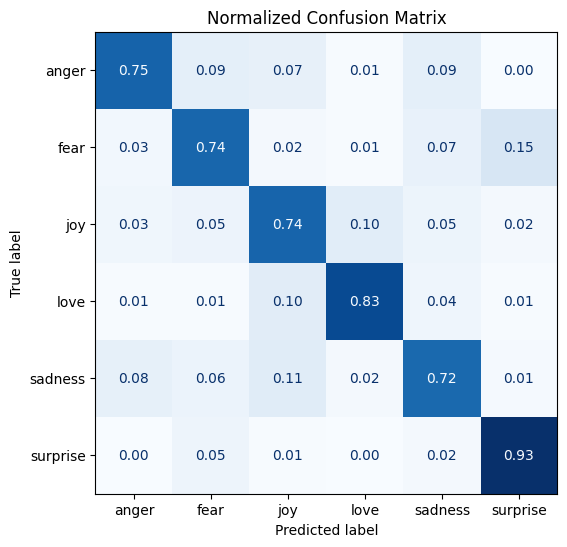

In [6]:

def plot_confusion_matrix(y_predicted, y_true, labels):
    cm = confusion_matrix(y_true, y_predicted, normalize='true')
    fig, ax = plt.subplots(figsize=(6, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap='Blues', values_format='.2f', ax=ax, colorbar=False)
    plt.title('Normalized Confusion Matrix')
    plt.show()

# Example usage
labels = df['label'].unique()  # Extract unique labels from the DataFrame
plot_confusion_matrix(y_pred, y_test, labels)
